In [1]:
from xai.policy import *
from xai.buffer import Buffer
from xai.bytes import GigaBytes
from numpy import uint8
from numpy.typing import NDArray
from xai.mnist import MNIST
import matplotlib.pyplot as plt

import mnist
import torch
import random
import shap
import numpy as np

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [13]:
latent_dim = 10
device = "cuda"

In [28]:
images = torch.from_numpy(mnist.train_images()).to(device=device)
images = images.float()/255.0

labels = torch.from_numpy(mnist.train_labels())
labels_one_hot = torch.zeros((labels.shape[0],latent_dim)).float().to(device=device)
labels_one_hot[torch.arange(0,labels.shape[0]),labels.int()] = 1.0

images.shape, labels_one_hot.shape

(torch.Size([60000, 28, 28]), torch.Size([60000, 10]))

In [15]:
encoder = Policy.new((28,28),latent_dim, hidden_activation="ReLU")
decoder = Policy.new(encoder.output_dim,encoder.input_dim, hidden_activation="ReLU")
autoencoder = encoder + decoder
autoencoder

Sequential(
  (0): Linear(in_features=784, out_features=526, bias=True)
  (1): ReLU()
  (2): Linear(in_features=526, out_features=268, bias=True)
  (3): ReLU()
  (4): Linear(in_features=268, out_features=10, bias=True)
  (5): Linear(in_features=10, out_features=268, bias=True)
  (6): ReLU()
  (7): Linear(in_features=268, out_features=526, bias=True)
  (8): ReLU()
  (9): Linear(in_features=526, out_features=784, bias=True)
)

In [16]:
stats = autoencoder.adam().fit(
    X=images,
    Y=images,
    epochs=1500,
    batch_size=128,
    loss_criterion="MSELoss",
    verbose=True,
    info="Autoencoder test"
)
stats[5:].plot_loss()

Loss: 0.018537: 100%|██████████| 1500/1500 [00:13<00:00, 108.66it/s]


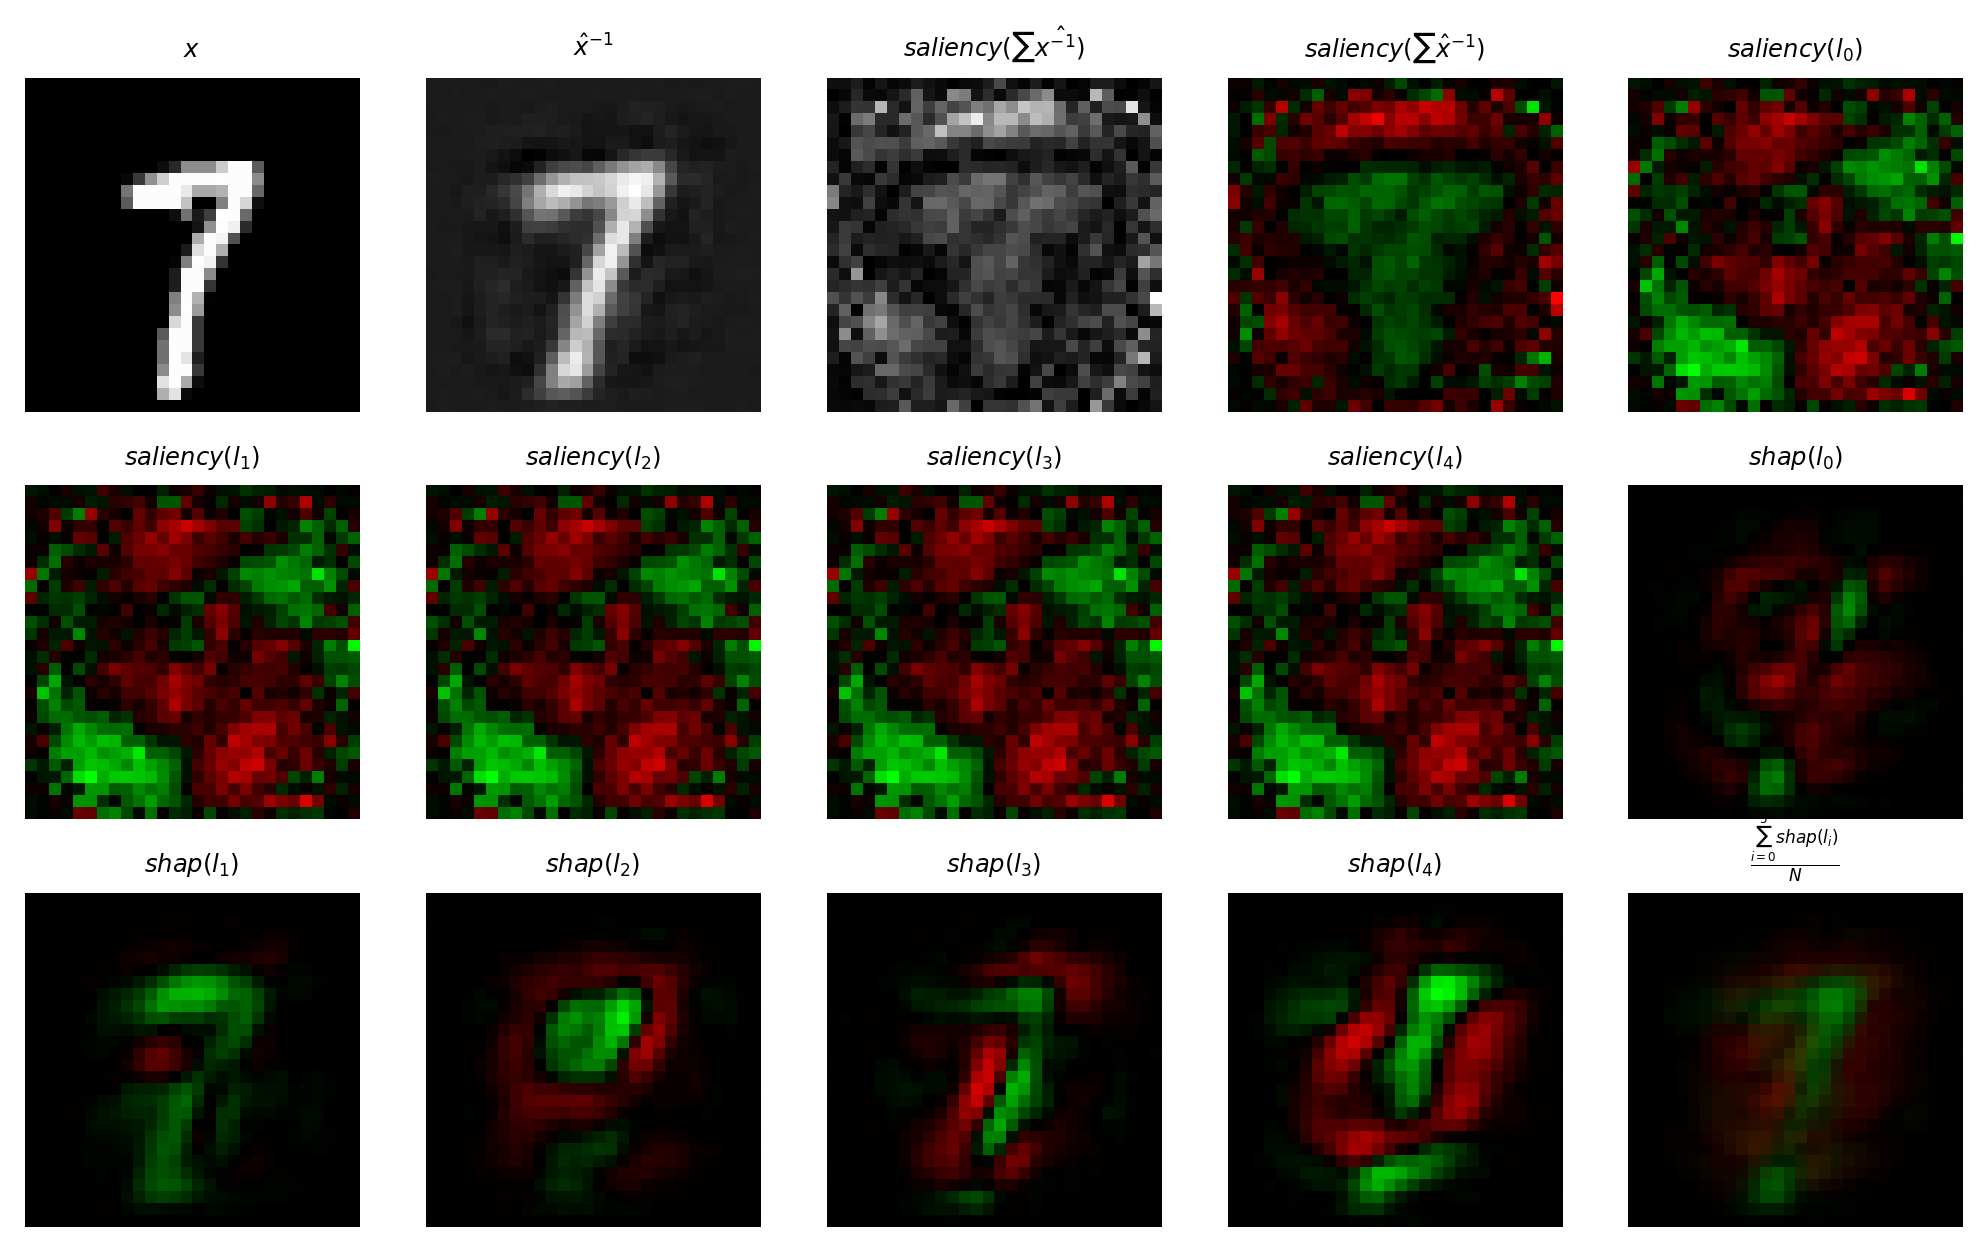

In [32]:
idx = random.randint(0,len(images))
X = images[idx]
L = encoder(X)
X_inv = autoencoder(X)
digit = X_inv.tensor(True).argmax().item()

fig = plt.figure(dpi=250, figsize=(10,6)) 
fig.add_subplot(3,5,1)
plt.imshow(X.numpy(force=True), cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

fig.add_subplot(3,5, 2)
plt.imshow(X_inv.numpy(), cmap="gray") 
plt.axis('off')
plt.title(f'$\\hat{{x}}^{{-1}}$', size=7)

abs_saliency = X_inv.saliency(lambda t: t.sum())

fig.add_subplot(3,5,3)
plt.imshow(abs_saliency.numpy(force=True), cmap="gray") 
plt.axis('off')
plt.title(f"$saliency(\sum{{\\hat{{x^{{-1}}}}}})$", size=7)

gradients = X_inv.gradients(lambda t: t.sum())
min,max = gradients.min(), gradients.max()
if abs(max) > abs(min):
    min = -max
else:
    max = -min
red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
saliency_with_corr = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
saliency_with_corr[:,:,0] = red
saliency_with_corr[:,:,1] = green

fig.add_subplot(3,5,4)
plt.imshow(saliency_with_corr.numpy(force=True), cmap="gray") 
plt.axis('off')
plt.title(f"$saliency(\sum{{\\hat{{x}}^{{-1}}}})$", size=7)

shap_images = []
for i in range(5):
    gradients = L.gradients(lambda t: t[0])
    min,max = gradients.min(), gradients.max()
    if abs(max) > abs(min):
        min = -max
    else:
        max = -min
    red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
    green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
    latent_saliency = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
    latent_saliency[:,:,0] = red
    latent_saliency[:,:,1] = green
    fig.add_subplot(3,5,i+5)
    plt.imshow(latent_saliency.numpy(force=True), cmap="gray")
    plt.axis('off')
    plt.title(f'$saliency(l_{i})$', size=7)

data = encoder(images).numpy()
explainer = shap.PermutationExplainer(lambda t: decoder(torch.from_numpy(t)).numpy().reshape((-1,784)), masker=data)
autoencoder_shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=21)[0]
autoencoder_shap_values = np.array(autoencoder_shap_values.values).reshape((latent_dim,28,28))

min,max = autoencoder_shap_values.min(), autoencoder_shap_values.max()
if abs(max) > abs(min):
    min = -max
else:
    max = -min
red = np.where(autoencoder_shap_values < 0, autoencoder_shap_values/min, np.zeros_like(autoencoder_shap_values))
green = np.where(autoencoder_shap_values > 0, autoencoder_shap_values/max, np.zeros_like(autoencoder_shap_values))

shap_images = []
for i in range(5):
    image = np.zeros((28,28,3), dtype=np.float32)
    image[:,:,0] = red[i]
    image[:,:,1] = green[i]
    shap_images.append(image)
    fig.add_subplot(3,5,i+10)
    plt.imshow(shap_images[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$shap(l_{i})$', size=7)

fig.add_subplot(3,5,15)
plt.imshow(np.stack(shap_images).mean(axis=0))
plt.axis('off')
plt.title(f'$\\frac{{\sum_{{i=0}}^{{5}}{{shap(l_{{i}})}}}}{{N}}$', size=7)
plt.show()

In [29]:
classifier_head = Policy.new(encoder.output_dim,10, hidden_activation="ReLU")
classifier = encoder + classifier_head
classifier

Sequential(
  (0): Linear(in_features=784, out_features=526, bias=True)
  (1): ReLU()
  (2): Linear(in_features=526, out_features=268, bias=True)
  (3): ReLU()
  (4): Linear(in_features=268, out_features=10, bias=True)
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=10, bias=True)
)

In [30]:
stats = classifier_head.adam().fit(
    X=encoder(images),
    Y=labels_one_hot.cuda(),
    epochs=5000,
    batch_size=64,
    loss_criterion="CrossEntropyLoss",
    verbose=True,
    info="Classifier test"
)
stats.plot_loss()

Loss: 0.322028: 100%|██████████| 5000/5000 [00:50<00:00, 98.51it/s] 


In [ ]:
idx = random.randint(0,len(images))
X = images[idx]
Y = classifier(X)
digit = Y.tensor(True).argmax().item()

fig = plt.figure(dpi=250, figsize=(10,5)) 
fig.add_subplot(4,7, 1)
plt.imshow(X, cmap="gray") 
plt.axis('off')
plt.title(f'$x$', size=7)

saliencies = []
for i in range(10):
    fig.add_subplot(4,7,i+2)
    saliencies.append(Y.saliency(lambda t: t[i]))
    plt.imshow(saliencies[-1], cmap="gray")
    plt.axis('off')
    plt.title(f'$\\frac{{dx}}{{d\hat y_{i}}}$', size=7)


for i in range(10):
    gradients = Y.gradients(lambda t: t.sum())
    min,max = gradients.min(), gradients.max()
    if abs(max) > abs(min):
        min = -max
    else:
        max = -min
    red = torch.where(gradients < 0, gradients/min, torch.zeros_like(gradients))
    green = torch.where(gradients > 0, gradients/max, torch.zeros_like(gradients))
    saliency_with_corr = torch.zeros((28,28,3), dtype=torch.float32, device="cpu")
    saliency_with_corr[:,:,0] = red
    saliency_with_corr[:,:,1] = green
    fig.add_subplot(4,7,i+12)
    plt.imshow(saliency_with_corr, cmap="gray")
    plt.axis('off')
    plt.title(f'$\\frac{{dx}}{{d\hat y_{i}}}$', size=7)


data = encoder(images).numpy()
explainer = shap.PermutationExplainer(lambda t: classifier_head(torch.from_numpy(t)).numpy().reshape((-1,10)), masker=data)
classifier_head_shap_values: shap.Explanation = explainer(data[idx:idx+1], max_evals=11)[0]
classifier_head_shap_values = np.array(classifier_head_shap_values.values).reshape((latent_dim,10))

classifier_head_shap_min, classifier_head_shap_max = classifier_head_shap_values.min(), classifier_head_shap_values.max()
if abs(classifier_head_shap_max) > abs(classifier_head_shap_min):
    classifier_head_shap_min = -classifier_head_shap_max
else:
    classifier_head_shap_max = -classifier_head_shap_min


negative = np.where(classifier_head_shap_values < 0, classifier_head_shap_values / classifier_head_shap_min, np.zeros_like(classifier_head_shap_values))
negative = negative / negative.sum(axis=0)

positive = np.where(classifier_head_shap_values > 0, classifier_head_shap_values / classifier_head_shap_max, np.zeros_like(classifier_head_shap_values))
positive = positive / positive.sum(axis=0)

positive.shape

In [ ]:
import shap

explainer = shap.GradientExplainer()
autoencoder_shap_values: shap.Explanation = explainer.shap_values(xi.unsqueeze(0))

explainer()